In [2]:
def maximumarray(a):
    maxsub = a[0]
    cursub = 0
    for n in a:
        if cursub < 0:
            cursub = 0
        cursub += n
        maxsub = max(maxsub, cursub)
        print(maxsub)
    return maxsub

a = [-2, 1, -3, 4, -1, 2, 1, -5, 4]
print(maximumarray(a)) 

-2
1
1
4
4
5
6
6
6
6


In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib

%matplotlib inline
from pprint import pprint
from groq import Groq
import os
from database_utils.query_data import get_ohlc_data
from constant import init_cerebro_object
from base_strategy import *

import pandas as pd
import influxdb_client
from influxdb_client import QueryApi
from database_utils.query_data import get_ohlc_data
import backtrader.strategies as btstrats

In [ ]:
token = "CTBcG6NRjd3982qIIokJ-gtQcy9IkWPUWo8IqNocyK97ZVtvnjjsZoz-VAPoOwoDu6nHtF2fkWk_tMbrNNC40A=="
org = "US-VNHCM"
url = "http://localhost:8086"
bucket = "my-Stock"


GROQ_API_KEY= "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"
client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)
read_api = client.query_api()
client = Groq(api_key=GROQ_API_KEY)

In [28]:
def get_code_from_text(text):
    code_segement = text.split("```")[1]
    if "```python" in text:
        code_segement = code_segement[6:]
    return code_segement.strip()

In [ ]:
data = get_ohlc_data(read_api=read_api, stock_code="ACB", from_date=10)
data["Date"] = data.index
data["Date"] = data["Date"].apply(
        lambda dt: dt.replace(tzinfo=None)
            )
data = data.resample("5min", on="Date", label="right").agg(
            {
                "Open": "first",
                "High": "max",
                "Low": "min",
                "Close": "last",
                "Volume": "sum",
            }
        ).reset_index()
data = data.dropna()
list_of_data = [bt.feeds.PandasData(
                dataname=data, datetime="Date", timeframe=bt.TimeFrame.Minutes
                )]

In [4]:
with open("base_strategy.py", "r") as f:
    base_strats = "\n".join(f.readlines())

In [5]:
prompt = "Please create a strategy that buy when RSI is below 50 and sell when RSI is above 80."
prompt = "Please create a strategy that buy position when MA1 > MA50, and close position after 10 cycle."

In [15]:
os.environ["ANYSCALE_API_BASE"] = "https://api.endpoints.anyscale.com/v1"
os.environ["ANYSCALE_API_KEY"] = "esecret_mxhfybv3ehvz954hihatkyqh24"

In [16]:
import os
from openai import OpenAI

client = OpenAI(
  api_key = os.environ['ANYSCALE_API_KEY'],
  base_url = os.environ['ANYSCALE_API_BASE']
)

In [17]:
system = f"""
You are a python developer that intent to make a workable strategy from human requirement.
Your task is to create a new BackTestStrategy that follow below msg
Note: Only return class strategy and change `execute` function only, nothing else

{prompt}

And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.
Please name your class strategy as BackTestStrategy
----------------------------
"{base_strats}"
"""
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": system,
        }
    ],
    model='meta-llama/Meta-Llama-3-70B-Instruct',
)

In [18]:
original_script = chat_completion.choices[0].message.content
print(original_script)

Here is the implementation of the `BackTestStrategy` class with the specified requirements:
```
class BackTestStrategy(BaseStrategy):
    params = (('pfast', 1), ('pslow', 50), ('cycle', 10))

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ma1 = bt.ind.MovingAverageSimple(self.data.close, period=self.params.pfast)
        self.ma50 = bt.ind.MovingAverageSimple(self.data.close, period=self.params.pslow)
        self.cycle_count = 0

    def execute(self):
        if self.ma1 > self.ma50:
            if not self.position:
                return 1
            else:
                self.cycle_count += 1
                if self.cycle_count >= self.params.cycle:
                    return -1
        else:
            self.cycle_count = 0
        return 0
```
Note that I added three parameters to the strategy: `pfast`, `pslow`, and `cycle`, which can be adjusted when creating an instance of the strategy.


In [19]:
revise = "I don't see where you close the position after hold_counter equal 0"
# revise = False
if revise:
    revise_system = f"""
    You are a python developer that intent to make a workable strategy from human requirement.
    Your task is to create a new BackTestStrategy that follow below msg
    Note: Only return class strategy with your change in execute function


    Please revise the below script based on requests: {revise}
    {original_script}
    """
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": revise_system,
            }
        ],
        model="meta-llama/Meta-Llama-3-70B-Instruct",
    )
    final_script = chat_completion.choices[0].message.content
else:
    final_script = original_script

In [20]:
print(final_script)

Here is the revised implementation of the `BackTestStrategy` class:
```
class BackTestStrategy(BaseStrategy):
    params = (('pfast', 1), ('pslow', 50), ('cycle', 10))

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ma1 = bt.ind.MovingAverageSimple(self.data.close, period=self.params.pfast)
        self.ma50 = bt.ind.MovingAverageSimple(self.data.close, period=self.params.pslow)
        self.cycle_count = 0
        self.position_size = 0

    def execute(self):
        if self.ma1 > self.ma50:
            if not self.position:
                self.position_size = 1
                return 1
            else:
                self.cycle_count += 1
                if self.cycle_count >= self.params.cycle:
                    self.position_size = -1
                    return -1
        else:
            if self.position_size > 0:
                self.position_size = -1
                return -1
            self.cycle_count = 0
        return

In [21]:
exec(get_code_from_text(final_script))

In [ ]:
list_of_data = [bt.feeds.PandasData(
                dataname=data, datetime="Date", timeframe=bt.TimeFrame.Minutes
                )]
cerebro = init_cerebro_object(strategy=BackTestStrategy, list_of_data=list_of_data, strategy_params=None, verbose=False, stake=100, cash=20_000)
thestrats = cerebro.run()
thestrat = thestrats[0]

In [ ]:
# Print out the final result
print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
print(
    "Total point return: ",
    (cerebro.broker.getvalue() - cerebro.broker.startingcash),
)

Final Portfolio Value: 2000.00
Total point return:  0.0


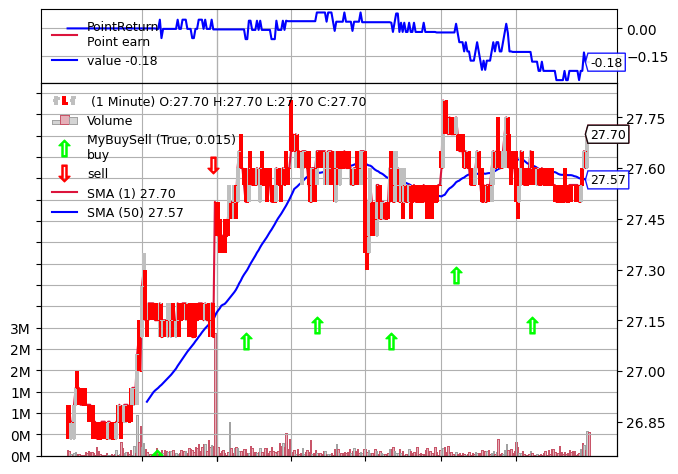

In [ ]:
figs = cerebro.plot(
        iplot=False, style="pincandle", width=32 * 10, height=18 * 10, dpi=300
    )

In [ ]:
for each in thestrat.analyzers:
    each.print()

DrawDown:
  - len: 181
  - drawdown: 0.024422566947738242
  - moneydown: 0.4885850000002847
  -----------------------------------------------------------------------------
  - max:
    - len: 181
    - drawdown: 0.029421199109543727
    - moneydown: 0.5885850000004211
TradeAnalyzer:
  -----------------------------------------------------------------------------
  - total:
    - total: 8
    - open: 1
    - closed: 7
  -----------------------------------------------------------------------------
  - streak:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - won:
      - current: 0
      - longest: 1
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - lost:
      - current: 6
      - longest: 6
  -----------------------------------------------------------------------------
  - pnl:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - gross:
      - total: 0.05000000000000071
      - aver

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import pandas as pd
import backtrader as bt
from openai import OpenAI
from base_strategy import *
import backtrader.strategies as btstrats

# Set environment variables for OpenAI
os.environ["ANYSCALE_API_BASE"] = "https://api.endpoints.anyscale.com/v1"
os.environ["ANYSCALE_API_KEY"] = "esecret_mxhfybv3ehvz954hihatkyqh24"

# Initialize the OpenAI client
client = OpenAI(
    api_key=os.environ['ANYSCALE_API_KEY'],
    base_url=os.environ['ANYSCALE_API_BASE']
)

def get_code_from_text(text):
    """Extracts the Python code segment from the provided text."""
    code_segment = text.split("```")[1]
    if "```python" in text:
        code_segment = code_segment[6:]
    return code_segment.strip()

def load_base_strategy():
    """Loads the base strategy code from the base_strategy.py file."""
    with open("base_strategy.py", "r") as f:
        base_strats = f.read()
    return base_strats

def load_data(data_path):
    """Loads OHLCV data from the specified path."""
    data = pd.read_csv(data_path, index_col='Date', parse_dates=True)
    return data

def debug_code_with_data(code_str, data_path):
    """Attempts to execute the provided code string with OHLCV data and captures errors if any."""
    try:
        local_vars = {}
        exec(code_str, globals(), local_vars)
        
        # Create a cerebro instance
        cerebro = bt.Cerebro()
        
        # Load data
        data = bt.feeds.PandasData(dataname=load_data(data_path))
        cerebro.adddata(data)
        
        # Add strategy
        strategy_class = local_vars['BackTestStrategy']
        cerebro.addstrategy(strategy_class)
        
        # Run the strategy
        cerebro.run()
        
        print("Code ran successfully.")
        return True, ""
    except Exception as e:
        error_message = str(e)
        print(f"Code execution failed with error: {error_message}")
        return False, error_message

def generate_strategy(prompt, base_strats):
    """Generates a new strategy based on the given prompt and base strategy."""
    system = f"""
    You are a python developer tasked with creating a workable strategy from human requirements.
    Your task is to create a new BackTestStrategy that follows the instructions below.
    Note: Only return the class strategy and change the `execute` function, nothing else.

    {prompt}

    Below is the structure of the codebase, including the MovingAverageStrategy as an example. Please name your class strategy as BackTestStrategy and change only the `execute` function.
    ----------------------------
    "{base_strats}"
    """
    
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": system,
            }
        ],
        model='meta-llama/Meta-Llama-3-70B-Instruct',
    )
    return chat_completion.choices[0].message.content

def revise_strategy(original_script, revise_prompt):
    """Revises the original strategy script based on the provided revision prompt."""
    revise_system = f"""
    You are a python developer tasked with creating a workable strategy from human requirements.
    Your task is to create a new BackTestStrategy that follows the instructions below.
    Note: Only return the class strategy with your changes in the `execute` function.

    Please revise the below script based on the requests: {revise_prompt}
    {original_script}
    """
    
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": revise_system,
            }
        ],
        model="meta-llama/Meta-Llama-3-70B-Instruct",
    )
    return chat_completion.choices[0].message.content

def add_prompt_and_error_messages(prompt, error_message):
    """Adds the prompt and error message to the generated code."""
    adjusted_prompt = f"{prompt}\n\nNote: The following error was encountered when running the code: {error_message}"
    return adjusted_prompt

def generate_and_check_code(prompt, base_strats, data_path, func=generate_strategy):
    """Generates and checks the strategy code based on the provided prompt."""
    generated_code = func(prompt, base_strats)
    success, error_message = debug_code_with_data(get_code_from_text(generated_code), data_path)
    return generated_code, success, error_message

def main():
    # Load the base strategy code
    base_strats = load_base_strategy()
    data_path = "E:\Projects\Trading_projects\AAPL.csv"  # Update this path to your OHLCV data file

    while True:
        # Initial code generation from user's input
        prompt = input("Please provide a prompt for the strategy code generation: ")
        # Generate and check the initial code
        generated_code, success, error_message = generate_and_check_code(prompt, base_strats, data_path)

        while True:
            if not success:
                # If the initial code fails, regenerate it with the error message
                prompt_with_error = add_prompt_and_error_messages(prompt, error_message)
                # Generate and check the code again
                generated_code, success, error_message = generate_and_check_code(prompt_with_error, base_strats, data_path)
            else:
                # If the initial code is successful, print it and break the loop
                print("strategy code:\n")
                print(generated_code)
                break

        while True:
            # Ask the user if they want to revise the strategy code
            revise_prompt = input("Please provide a revision prompt to adjust the strategy code or type 'stop' to finish: ")

            # If the user wants to stop, break the loop
            if revise_prompt.lower() == "stop":
                break

            # Generate and check the revised code
            revised_code, success, error_message = generate_and_check_code(generated_code, revise_prompt, data_path, revise_strategy)

            # If the revised code fails, regenerate it with the error message
            if not success:
                print(f"Revision attempt failed with error: {error_message}")
                prompt_with_error = add_prompt_and_error_messages(revise_prompt, error_message)
                generated_code = revise_strategy(generated_code, prompt_with_error)
            else:
                generated_code = revised_code
                print("Revised strategy executed successfully.")
                print(generated_code)
        
        stop_execution = input("Do you want to stop? (yes/no): ")
        if stop_execution.lower() == "yes":
            break

if __name__ == '__main__':
    main()


Code ran successfully.
strategy code:

Here is the new strategy class `BackTestStrategy` with the modified `execute` method:
```
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ma1 = bt.ind.SMA(self.data.close, period=1)
        self.ma50 = bt.ind.SMA(self.data.close, period=50)
        self.cycle_count = 0

    def execute(self):
        if self.ma1 > self.ma50:
            if self.position.size == 0:
                self.cycle_count = 0
                return 1
            else:
                self.cycle_count += 1
                if self.cycle_count >= 10:
                    return -1
                else:
                    return 0
        else:
            return 0
```
This strategy buys when the short-term moving average (MA1) is above the long-term moving average (MA50), and closes the position after 10 cycles. The `execute` method returns 1 to indicate a buy signal, -1 to indicate a sell s

KeyboardInterrupt: 